In [235]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Compose, PILToTensor, ToTensor
import PIL
import torch
import torchvision as torchvision

from dataset import CropSegmentationDataset
from am4ip.new_trainer import BaselineTrainer

from torch.utils.data import DataLoader

from am4ip.losses import FocalLoss

In [245]:
batch_size = 6
lr = 1e-3
epoch = 45

In [237]:
transform = Compose([lambda z: z.resize((256,256),PIL.Image.BILINEAR), 
                     PILToTensor(),
                     lambda z: z.to(dtype=torch.float32) / 127.5 - 1  # Normalize between -1 and 1
                     ])

target_transform = Compose([lambda z: z.resize((256,256),PIL.Image.NEAREST),
                            PILToTensor(),
                            lambda z : z.to(dtype=torch.int64).squeeze(0)
                     ])

In [238]:
dataset_train = CropSegmentationDataset(set_type="train", transform=transform, target_transform = target_transform, remove_small_items = True, merge_small_items=False)
dataset_test = CropSegmentationDataset(set_type="test", transform = transform, merge_small_items=False )
dataset_val = CropSegmentationDataset(set_type="val", target_transform = target_transform, transform = transform, remove_small_items = True, merge_small_items=False)
dataset = dataset_train + dataset_val

In [239]:
print("len of dataset_train = ", dataset_train.__len__())
print("len of dataset_test = ", dataset_test.__len__())
print("len of dataset_val = ", dataset_val.__len__())
print("len of dataset = ", dataset.__len__())

len of dataset_train =  1407
len of dataset_test =  350
len of dataset_val =  422
len of dataset =  1829


In [6]:
# to have only one array
segmentations = np.concatenate([seg for _, seg in dataset])

# count the nb of pixel of each class
class_counts = np.bincount(segmentations.flatten(), minlength=3)
print(class_counts)

# calculate the weight of each class
num_classes = len(class_counts)
total_samples = len(segmentations)

class_weights = 1 / (class_counts / total_samples)

print("Class Weights:", class_weights)

[108943007  10443046    479291]
Class Weights: [0.00429788 0.04483596 0.97690964]


In [7]:
print(len(segmentations.flatten()))
print(len(class_counts))

119865344
3


In [8]:
dataset_train

In [9]:
t0 = dataset_val[0]

In [10]:
print(type(dataset_train))
print(type(dataset_train[0]))

print(type(dataset_test))
print(t0)

<class 'dataset.CropSegmentationDataset'>
<class 'tuple'>
<class 'dataset.CropSegmentationDataset'>
(tensor([[[ 0.4510,  0.5059,  0.4980,  ...,  0.2784,  0.2314, -0.1216],
         [ 0.0510,  0.2471,  0.5059,  ...,  0.0980,  0.1059, -0.0431],
         [-0.2392,  0.2314,  0.3333,  ..., -0.3412, -0.1137, -0.4118],
         ...,
         [ 0.0824, -0.5529,  0.0353,  ...,  0.1765, -0.0196,  0.1216],
         [ 0.1059, -0.2706,  0.1294,  ...,  0.1529,  0.1686,  0.3804],
         [ 0.3333,  0.2863,  0.1843,  ...,  0.1216,  0.4353,  0.2941]],

        [[ 0.1216,  0.1608,  0.1608,  ..., -0.0510, -0.0824, -0.4118],
         [-0.2471, -0.0824,  0.1686,  ..., -0.2314, -0.1843, -0.3255],
         [-0.5059, -0.0824, -0.0118,  ..., -0.5686, -0.3647, -0.5765],
         ...,
         [-0.1843, -0.6863, -0.2000,  ..., -0.1608, -0.3098, -0.1922],
         [-0.1843, -0.4980, -0.1608,  ..., -0.1843, -0.1373,  0.0667],
         [ 0.0275, -0.0039, -0.1216,  ..., -0.2078,  0.1294, -0.0196]],

        [[-0.20

In [11]:
t1 = dataset_train[620]

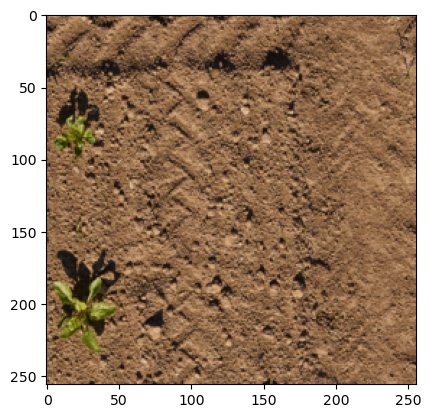

In [12]:
plt.imshow((t0[0].permute(1,2,0)+1) * 0.5)

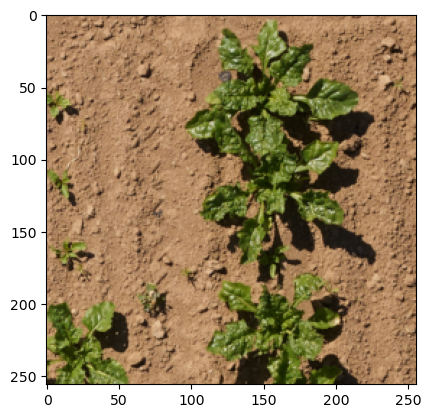

In [13]:
plt.imshow((t1[0].permute(1,2,0)+1) * 0.5)

In [14]:
print(t1[0])

tensor([[[ 0.5294,  0.4275,  0.2784,  ...,  0.5373,  0.5216,  0.5608],
         [ 0.4510,  0.4039,  0.5059,  ...,  0.4196,  0.4667,  0.5294],
         [ 0.4275,  0.2784,  0.4118,  ...,  0.5059,  0.3725,  0.5451],
         ...,
         [-0.6784, -0.6863, -0.6706,  ..., -0.0745,  0.3255,  0.3020],
         [-0.6706, -0.7255, -0.7176,  ...,  0.2314,  0.4824,  0.2471],
         [-0.6784, -0.7333, -0.7255,  ...,  0.3412,  0.3647,  0.4510]],

        [[ 0.2392,  0.0980, -0.0431,  ...,  0.2157,  0.1843,  0.2314],
         [ 0.1216,  0.0824,  0.2078,  ...,  0.0824,  0.1373,  0.2000],
         [ 0.0902, -0.0510,  0.0980,  ...,  0.1608,  0.0510,  0.2157],
         ...,
         [-0.7412, -0.7490, -0.7490,  ..., -0.3333,  0.0118, -0.0118],
         [-0.7333, -0.7882, -0.7804,  ..., -0.0745,  0.1608, -0.0510],
         [-0.7333, -0.7882, -0.7804,  ...,  0.0196,  0.0510,  0.1451]],

        [[-0.0588, -0.1765, -0.3020,  ..., -0.1059, -0.1373, -0.0902],
         [-0.1686, -0.2000, -0.0980,  ..., -0

In [15]:
print(t1[1][10][10])

tensor(0)


In [16]:
t1_1array = np.array(t1[1]).squeeze()

print(np.max(t1_1array))

2


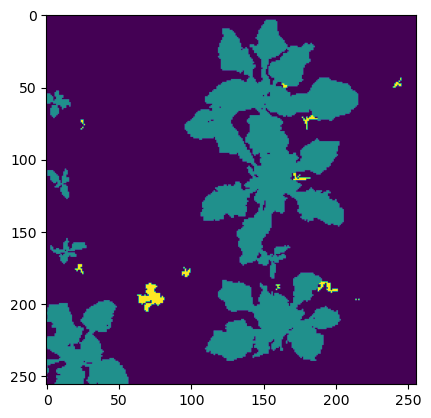

In [17]:
plt.imshow(t1_1array)

In [18]:
def target_pixel(img):
    img = np.array(img).squeeze()
    
    print(img.shape)
    

target_pixel(t1[1])

(256, 256)


In [19]:
def create_model(n):
    encoder = torch.nn.Sequential(
        torch.nn.Conv2d(3,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,64,(3,3)),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,64,(3,3)),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.MaxPool2d((2,2),2),
        
        torch.nn.Conv2d(64,128,(3,3)),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3)),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3)),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3)),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
    
        torch.nn.MaxPool2d((2,2),2),
    
        torch.nn.Conv2d(128,256,(3,3)),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3)),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3)),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3)),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU()
    )

    reconstruction = torch.nn.Sequential(
        torch.nn.Conv2d(3,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.MaxPool2d((2,2),2),
        
        torch.nn.Conv2d(64,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.MaxPool2d((2,2),2),
    
        torch.nn.Conv2d(128,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(256,256,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(256),
        torch.nn.ReLU(),
        
        torch.nn.Upsample(scale_factor=2),
        
        torch.nn.Conv2d(256,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(128,128,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(128),
        torch.nn.ReLU(),
        
        torch.nn.Upsample(scale_factor=2),
        
        torch.nn.Conv2d(128,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,64,(3,3), padding = 'same'),
        torch.nn.BatchNorm2d(64),
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(64,n,(3,3), padding = 'same'),
    )

    return encoder, reconstruction

In [240]:
encoder, reconstruction = create_model(3)
model = torch.load('recon105epoch_focal_loss.pt')

In [241]:
# for FocalLoss
class_weights = torch.FloatTensor(class_weights)

loss = FocalLoss(alpha=class_weights, gamma=2)

In [242]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [243]:
trainer = BaselineTrainer(model=model, loss = loss, optimizer=optimizer)

In [244]:
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [246]:
hist = trainer.fit(train_loader, val_loader, epoch=epoch)

Start epoch 1/45
Validation 71/71: loss = 0.0008013708747326541
Start epoch 2/45
Validation 71/71: loss = 0.0007855520878006822
Start epoch 3/45
Validation 71/71: loss = 0.0007839545703486597
Start epoch 4/45
Validation 71/71: loss = 0.0008356256404740762
Start epoch 5/45
Validation 71/71: loss = 0.0008068789086881763
Start epoch 6/45
Validation 71/71: loss = 0.0008032423293244251
Start epoch 7/45
Validation 71/71: loss = 0.0008168297423817165
Start epoch 8/45
Validation 71/71: loss = 0.0008692646318797399
Start epoch 9/45
Validation 71/71: loss = 0.0008112906156973519
Start epoch 10/45
Validation 71/71: loss = 0.0008385570282870772
Start epoch 11/45
Validation 71/71: loss = 0.0008043491049558187
Start epoch 12/45
Validation 71/71: loss = 0.0008141381217619325
Start epoch 13/45
Validation 71/71: loss = 0.0008017130685530765
Start epoch 14/45
Validation 71/71: loss = 0.0008074668077030547
Start epoch 15/45
Validation 71/71: loss = 0.0008241220756145326
Start epoch 16/45
Validation 71/71

In [247]:
import pickle
with open('history_focal_loss_150epoch.pkl', 'wb') as file:
    pickle.dump(hist, file)

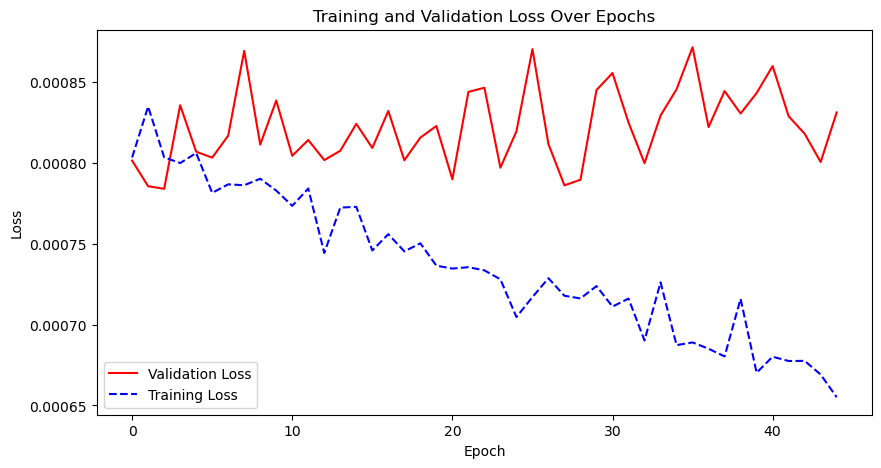

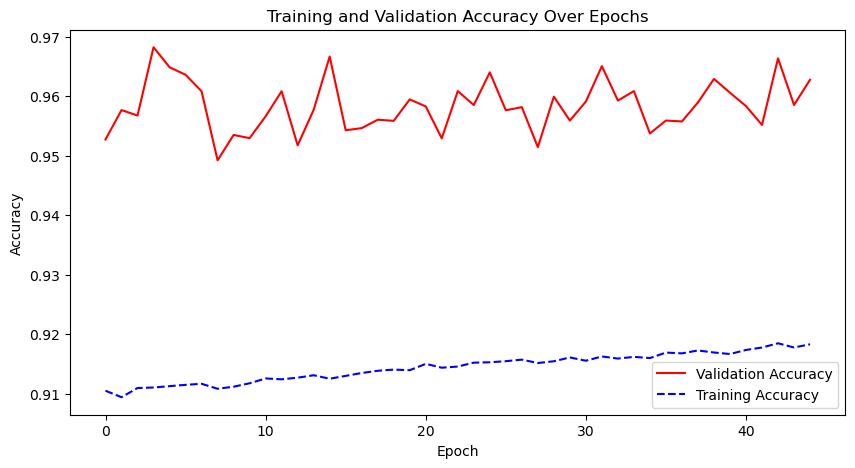

In [248]:
val_loss_hist = hist['val_loss']
val_accuracy_hist = hist['val_accuracy']
train_loss_hist = hist['train_loss']
train_accuracy_hist = hist['train_accuracy']

# Courbe de perte de validation
plt.figure(figsize=(10, 5))
plt.plot(val_loss_hist, label='Validation Loss', color='red')
plt.plot(train_loss_hist, label='Training Loss', color='blue', linestyle='dashed')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('focal_loss_loss_150_epoch.png')
plt.show()

# Courbe de précision de validation
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy_hist, label='Validation Accuracy', color='red')
plt.plot(train_accuracy_hist, label='Training Accuracy', color='blue', linestyle='dashed')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('focal_loss_accuracy_150_epoch.png')
plt.show()

In [122]:
len(dataset_train)

1407

In [249]:
t0 = dataset_val[16]
# model = torch.load('recon45epoch_focal_loss.pt')
# trainer = BaselineTrainer(model=model, loss = loss, optimizer=optimizer)

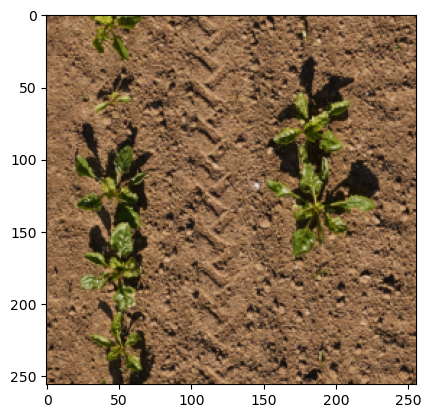

In [250]:
i_drone = (t0[0].permute(1,2,0)+1) * 0.5
plt.imshow(i_drone)

In [251]:
test = trainer.model.forward(t0[0].unsqueeze(0).cuda())

In [252]:
test.size()

torch.Size([1, 3, 256, 256])

In [253]:
test = test.cpu().detach()
test1 = test.squeeze(0)
i = torch.softmax(test1, 0)

In [254]:
print(i[:, 120, 120])

tensor([0.8602, 0.0373, 0.1025])


In [255]:
print(np.sum(i[:, 120, 120].numpy()))

print(len(i))

1.0000001
3


In [256]:
i_merged = torch.stack([i[0], i[1], i[2]])
i_result = torch.argmax(i_merged, dim=0)

print(type(i[0]))
print(type(i[1]))
print(type(i[2]))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


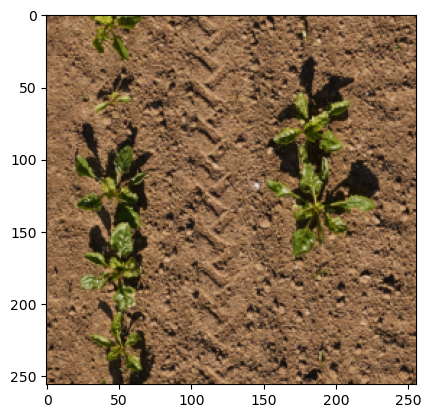

In [257]:
i_drone = (t0[0].permute(1,2,0)+1) * 0.5
plt.imshow(i_drone)
test = trainer.model.forward(t0[0].unsqueeze(0).cuda())
test = test.cpu().detach()
test1 = test.squeeze(0)
i = torch.softmax(test1, 0)
i_merged = torch.stack([i[0], i[1], i[2]])
i_result = torch.argmax(i_merged, dim=0)

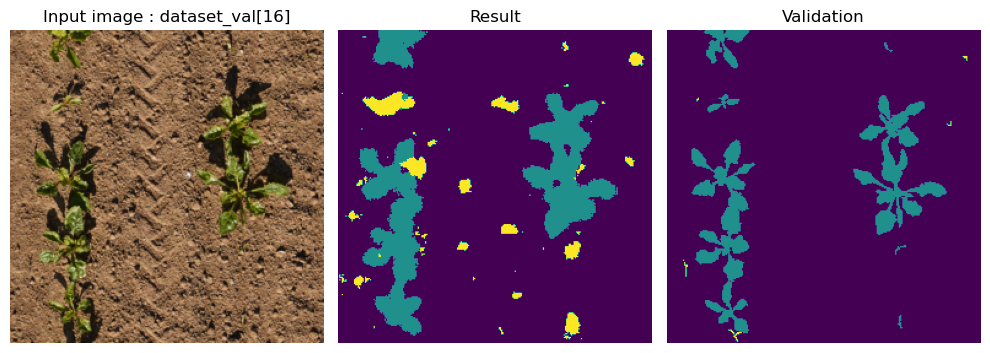

In [258]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(i_drone)
axes[0].set_title('Input image : dataset_val[16]')
axes[0].axis('off')
axes[1].imshow(i_result)
axes[1].set_title('Result')
axes[1].axis('off')
axes[2].imshow(np.array(t0[1]).squeeze())
axes[2].set_title('Validation')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('result_recon_focalloss_150epoch.png')
plt.show()